## Data analysis
1. Distribution of logP values
2. Generate Morgan fingerprints
3. Compare FPNN's fingerprints with Morgan

In [1]:
%load_ext autoreload
%autoreload 2

### 1. Distribution of logP values

In [2]:
# Load data (data also contains "MOL" object)
from data.Zinc_torch import Zinc_mod, Zinc_loader
from data.transform import Binning, NormalizeTarget

data = Zinc_mod(
                root="data/Zinc/", 
                #transform=Binning("models/zinc_bins_freq_10.npz")
                #transform=NormalizeTarget("models/zinc_std_scaler_qed_sas_logp.pkl", 3)
                )
                
loader = Zinc_loader(data, subset=True, batch_size=10000)

/home/akshay/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index


In [3]:
for b in loader.train_dataloader():
    break

In [4]:
np.mean(b.y.numpy(), axis=0), np.std(b.target.numpy(), axis=0)

NameError: name 'np' is not defined

In [4]:
import numpy as np
import torch

targets = np.array([i.y[0,:].numpy() for i in data])

train_targets = targets[loader.slices["train"]]
val_targets = targets[loader.slices["val"]]
test_targets = targets[loader.slices["test"]]

In [5]:
print("No. of train molecules : ", len(train_targets))
print("No. of test molecules : ", len(test_targets))

No. of train molecules :  10000
No. of test molecules :  1000


In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(train_targets)
ax[0].set_title("Train targets")

ax[1].hist(val_targets)
ax[1].set_title("Val targets")

ax[2].hist(test_targets)
ax[2].set_title("Test targets")

Text(0.5, 1.0, 'Test targets')

In [364]:
np.min(train_targets), np.min(test_targets)

(-3.769, -2.331)

In [365]:
np.max(train_targets), np.max(test_targets)

(4.01, 3.499)

In [19]:
val_targets.shape

(1000, 3)

In [10]:
data[0].y

tensor([[0.7020, 2.0841, 5.0506]])

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train_targets)

t1 = scaler.transform(train_targets)
t2 = scaler.transform(val_targets)
t3 = scaler.transform(test_targets)

In [23]:
np.mean(t3, axis=0), np.std(t3, axis=0)

(array([ 0.0451768 , -0.01166413,  0.04006772], dtype=float32),
 array([0.94448394, 0.98824674, 1.0072708 ], dtype=float32))

In [24]:
import pickle

pickle.dump(scaler, open("models/zinc_std_scaler_qed_sas_logp.pkl", "wb"))

In [25]:
s2 = pickle.load(open("models/zinc_std_scaler_qed_sas_logp.pkl", "rb"))

t4 = s2.transform(train_targets)

np.mean(t4, axis=0), np.std(t4, axis=0)

(array([-4.1395428e-08, -4.1127204e-09,  9.1910364e-09], dtype=float32),
 array([0.9999991, 1.0000006, 1.0000002], dtype=float32))

### 2. Generate Morgan and MACCS fingerprints

In [7]:
# Randomly select N molecules
import random

N = 500

graphs = random.sample( list(data[loader.slices["train"]]), N)
mols = [i.mol for i in graphs]

/home/akshay/miniforge3/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


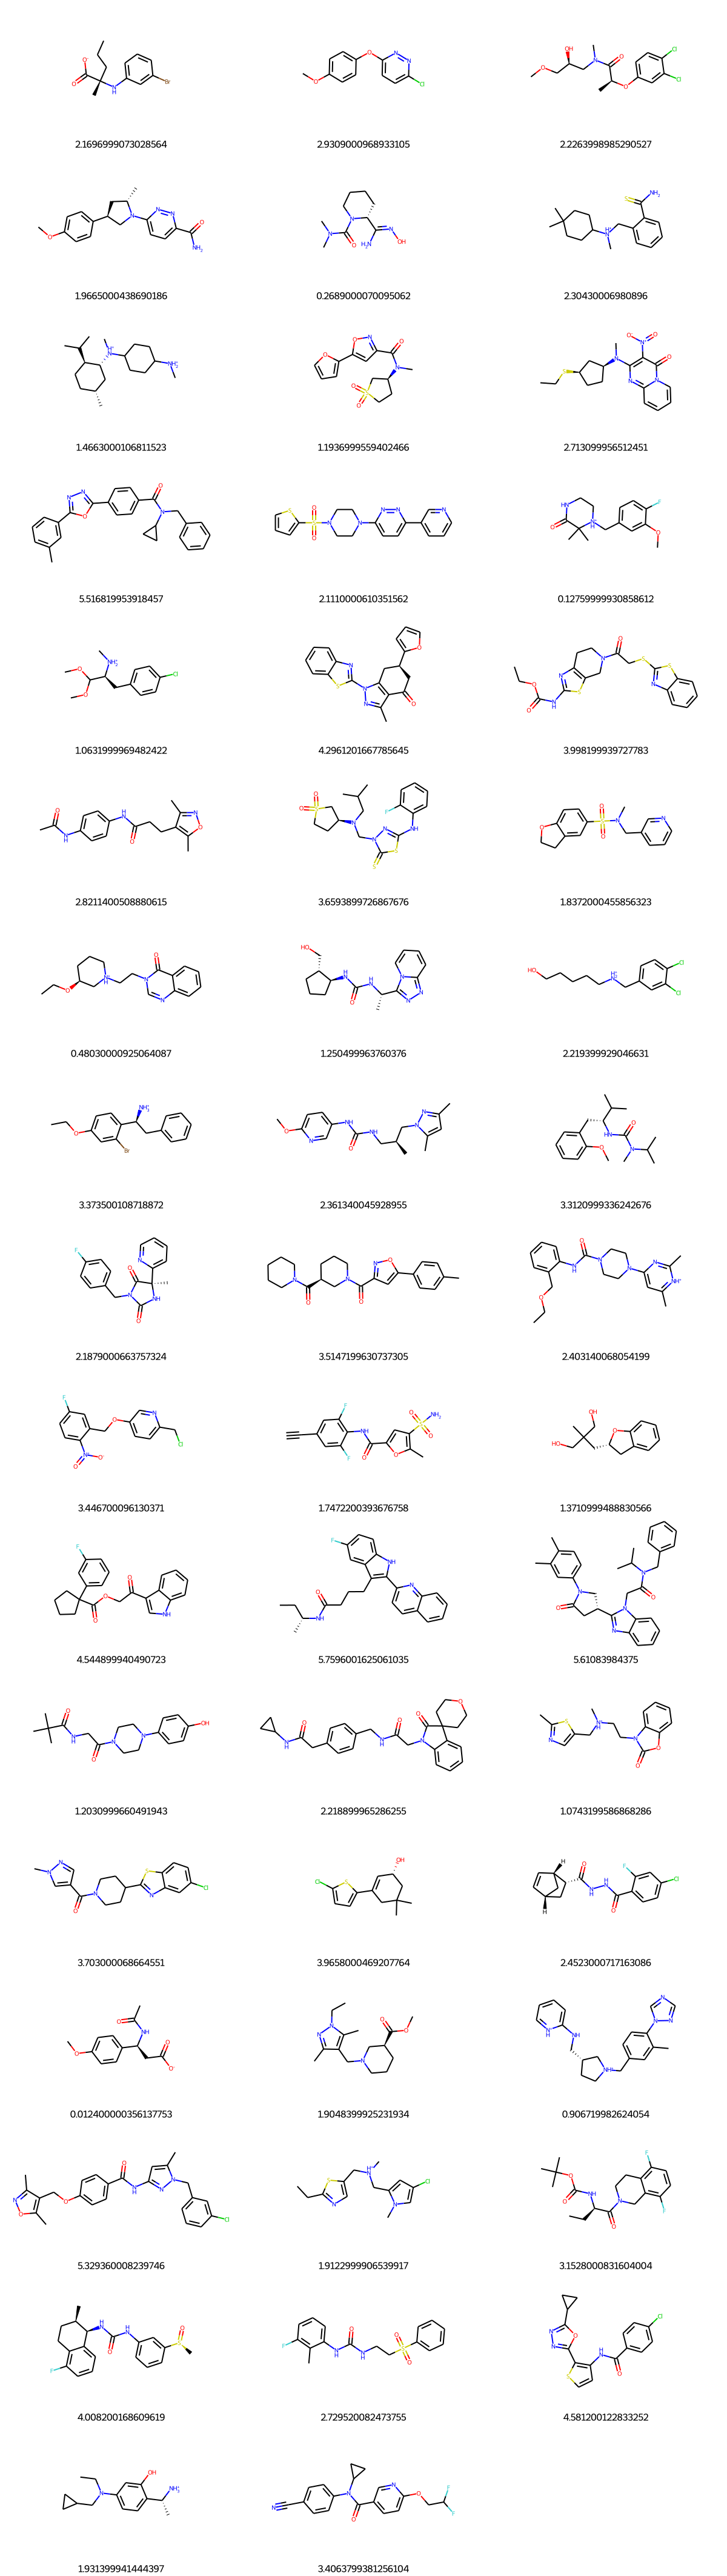

In [8]:
from rdkit.Chem import AllChem, Draw
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400,250),
                    legends=[str(i.y[:,-1].item()) for i in graphs])

In [9]:
#from models.fp import FPNN_v2
import numpy as np
from torch_geometric.data import DataLoader
from data.transform import NeuralFP_TD, NeuralFP_continous, MorganFP, MaccsFP

for batch in DataLoader(graphs, batch_size=len(graphs)):
    pass

/home/akshay/miniforge3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
# Define continous tanimoto similarity
def tanimoto(fp1,fp2):
    num = sum(min(fp1[i], fp2[i]) for i in range(len(fp1)))
    den = sum(max(fp1[i], fp2[i]) for i in range(len(fp1)))
    return 1 - num/den

def tanimoto_binary(a, b):
    Na = sum(a) # On items
    Nb = sum(b)
    Nc = np.dot(a, b) # Common ONs
    return Nc / (Na+Nb-Nc)

In [67]:
# Generate Tanimoto similarity matrix for MOrgan fingerprint
# from rdkit import DataStructs


# morgan = []
# for i in range(N):
#     fp1 = AllChem.GetMorganFingerprintAsBitVect(mols[i],2, nBits=512) # 2 indicates circular fingerprint
#     for j in range(i+1,N):
#         fp2 = AllChem.GetMorganFingerprintAsBitVect(mols[j],2, nBits=512)
#         morgan.append( DataStructs.TanimotoSimilarity(fp1, fp2) )

In [11]:
morgan = []

morgan_transform = MorganFP()
morgan_fps = morgan_transform(batch).fp.numpy()

for i in range(N):
    for j in range(i+1,N):
        morgan.append( tanimoto_binary(morgan_fps[i], morgan_fps[j]) )

In [72]:
# from rdkit.Chem import MACCSkeys
# from rdkit import DataStructs

# maccs = []
# for i in range(N):
#     fp1 = MACCSkeys.GenMACCSKeys(mols[i]) 
#     for j in range(i+1,N):
#         fp2 = MACCSkeys.GenMACCSKeys(mols[j]) 
#         maccs.append( DataStructs.TanimotoSimilarity(fp1, fp2) )

In [12]:
maccs = []

maccs_transform = MaccsFP()
maccs_fps = maccs_transform(batch).fp.numpy()

for i in range(N):
    for j in range(i+1,N):
        maccs.append( tanimoto_binary(maccs_fps[i], maccs_fps[j]) )

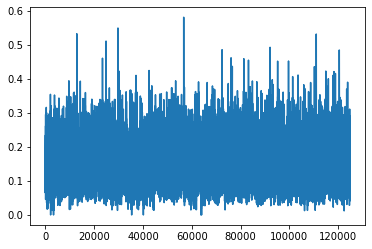

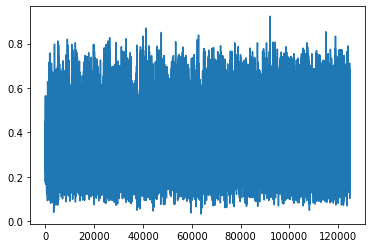

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(morgan)
plt.show()

plt.plot(maccs)

### 3. Compare FPNN's fingerprints with Morgan

In [14]:


#transform = NeuralFP("checkpoints/fpnn/fpnn_large_v3.pt")
fp_transform = NeuralFP_continous("models/gnn_fp_continous_256.pt")

batch = fp_transform(batch)
fps = batch.fp.detach().numpy()

In [90]:
# fp_transform = NeuralFP_TD("models/td_neural_fp.pt")

# batch = fp_transform(batch)
# fps = batch.fp.detach().numpy()

NameError: name 'DataBatch' is not defined

In [72]:
def scale_Weights(model, scale):
    for param in model.parameters():
        param.data *= scale

In [101]:
# scale_Weights(model, 5)

In [16]:
fpnn_sim = []
for i in range(N):
    for j in range(i+1,N):
        #fpnn_sim.append( tanimoto_binary(fps[i], fps[j]) )
        fpnn_sim.append( tanimoto(fps[i], fps[j]) )

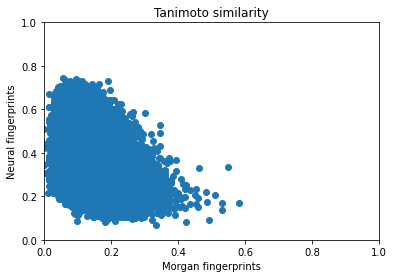

In [17]:
# PLot regression plot
plt.scatter(  morgan, fpnn_sim )
#plt.plot(np.linspace(0,0.35,10), np.linspace(0,0.35,10), "r")
plt.xlabel("Morgan fingerprints")
plt.ylabel("Neural fingerprints")
plt.title("Tanimoto similarity")

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [87]:
from scipy.stats import linregress

res = linregress(morgan, fpnn_sim)

res.slope, res.rvalue**2

(-0.565196839186798, 0.040238581305424646)

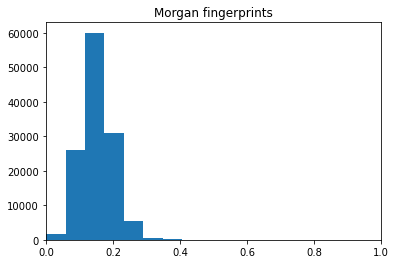

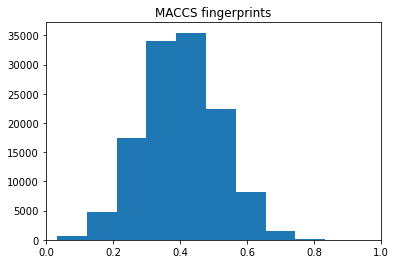

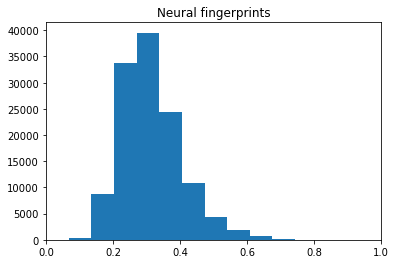

In [18]:
# PLot histograms
plt.hist(morgan)
plt.title("Morgan fingerprints")
plt.xlim([0,1])
plt.show()

plt.hist(maccs) 
plt.title("MACCS fingerprints") 
plt.xlim([0,1]) 
plt.show() 

plt.hist(fpnn_sim)
plt.title("Neural fingerprints")
plt.xlim([0,1])
plt.show()

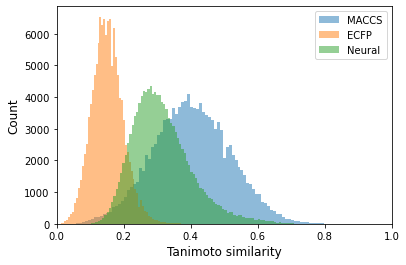

In [21]:
import numpy as np

xlim = [0, 1]
ylmi = [0, 25000]
bins = 100

a = np.array(maccs)
#np.array(fpnn_sim)-np.array(maccs)
b = np.array(morgan)
#np.array(fpnn_sim)-np.array(morgan)
c = np.array(fpnn_sim)
#np.array(maccs)-np.array(morgan)

plt_a = a#np.square(a)
plt_b = b#np.square(b)
plt_c = c#np.square(c)

# plt.hist( plt_a, bins=bins, label="Neural v/s MACCS", alpha=0.5)
# plt.hist( plt_b, bins=bins, label="Neural v/s Morgan", alpha=0.5)
# plt.hist( plt_c, bins=bins, label="MACCS vs Morgan", alpha=0.5)

plt.hist( plt_a, bins=bins, label="MACCS", alpha=0.5)
plt.hist( plt_b, bins=bins, label="ECFP", alpha=0.5)
plt.hist( plt_c, bins=bins, label="Neural", alpha=0.5)

plt.xlim(xlim)
plt.legend(loc='upper right')
#plt.xlabel("Difference of Tanimoto similarities", size=12)
plt.xlabel("Tanimoto similarity", size=12)
plt.ylabel("Count", size=12)
plt.savefig("logs/hist.png", bbox_inches="tight")

### T-SNE and PCA of neural fingerprints

In [35]:
from sklearn.manifold import TSNE

fps_tsne = TSNE().fit_transform(fps)
print(fps_tsne.shape)

/home/akshay/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/akshay/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(500, 2)


In [37]:
batch.y

tensor([[ 0.8038,  3.0026,  2.0102],
        [ 0.8048,  2.7685,  3.0858],
        [ 0.8617,  4.0309,  1.7769],
        ...,
        [ 0.7233,  4.6134, -0.9529],
        [ 0.7510,  4.2797,  0.3752],
        [ 0.6161,  1.5627,  3.1913]])

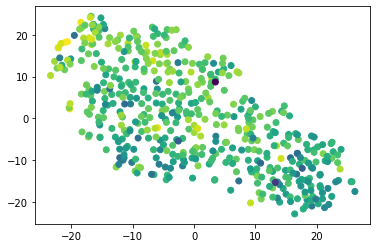

In [44]:
plt.scatter(fps_tsne[:,0], fps_tsne[:,1], c=batch.y.numpy()[:,2])

In [ ]:
from sklearn.decomposition import PCA

fps_tsne = PCA().fit_transform(fps)
print(fps_tsne.shape)

In [520]:
s = fp1.ToBitString()
a1 = np.fromstring(s,'u1') - ord('0')

s = fp2.ToBitString()
a2 = np.fromstring(s,'u1') - ord('0')

/tmp/ipykernel_968/2708199507.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(s,'u1') - ord('0')
/tmp/ipykernel_968/2708199507.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(s,'u1') - ord('0')


In [23]:
from rdkit.Chem import MACCSkeys
import numpy as np
np.seterr(all="ignore")

s = MACCSkeys.GenMACCSKeys(data[0].mol)

def fp_to_binary_vector(fp):
    s = fp.ToBitString()
    return np.fromstring(s,'u1') - ord('0')

fp_to_binary_vector(s)

/tmp/ipykernel_27203/2538682153.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(s,'u1') - ord('0')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0], dtype=uint8)

In [521]:
tanimoto_binary(a1, a2)

0.12857142857142856

In [30]:
import torch
probs = torch.randn(20, 10)
max_idx = torch.argmax(probs, 1, keepdim=True)
one_hot = torch.zeros(probs.size())
one_hot.scatter_(1, max_idx, 1)

max_idx

tensor([[1],
        [1],
        [0],
        [6],
        [3],
        [9],
        [6],
        [1],
        [2],
        [7],
        [9],
        [1],
        [6],
        [9],
        [4],
        [3],
        [4],
        [6],
        [0],
        [1]])

In [38]:
a = torch.randn(4,2)
b = a.prod(dim=1)
b

tensor([-0.0315,  0.1826,  0.6175,  0.0250])

In [40]:
prob = torch.zeros((4,3))

prob[:,0] = b
prob

tensor([[-0.0315,  0.0000,  0.0000],
        [ 0.1826,  0.0000,  0.0000],
        [ 0.6175,  0.0000,  0.0000],
        [ 0.0250,  0.0000,  0.0000]])

In [58]:
prob[:,-1:]

tensor([[0.],
        [0.],
        [0.],
        [0.]])

In [55]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([2, 4, 3])

In [54]:
import torch.nn.functional as F

F.one_hot( torch.arange(0, 5), num_classes=6)
torch.argmax(a, dim=1)

tensor([0, 0, 3])

In [412]:
t1 = np.array([0,1,0,1,0])
t2 = np.array([0,0,1,1,0])

tanimoto_binary(t1, t2)

0.3333333333333333

In [413]:
tanimoto_binary(1-t1, 1-t2)

0.5

In [414]:
tanimoto_binary(np.concatenate((t1, 1-t1)), np.concatenate((t2,1-t2)) )

0.42857142857142855

In [369]:
from scipy.stats import linregress

res = linregress(morgan, fpnn_sim)

res.slope

0.41625115669029605

In [66]:
len(train_targets)

10000

In [132]:
for b in loader.train_dataloader():
    break

In [133]:
fp = prop.fpnn(b)

In [134]:
fp[0]

tensor([0.4489, 1.0491, 0.5936, 0.5254, 0.6416, 0.8952, 0.9424, 0.4598, 0.5949,
        2.3322, 0.5857, 0.5602, 0.5182, 0.8353, 0.5335, 0.2239, 0.4814, 1.4835,
        0.7138, 0.7274, 1.0297, 0.4937, 0.4569, 0.9820, 0.5423, 0.5265, 0.7066,
        0.4088, 0.7273, 1.2504, 0.3681, 0.3618], grad_fn=<SelectBackward>)

In [68]:
import pickle

scaler = pickle.load(open("models/zinc_logP_scaler.pkl", "rb") )

In [69]:
type(scaler)

sklearn.preprocessing._data.MinMaxScaler

In [70]:
from sklearn.preprocessing import StandardScaler

In [76]:
s = StandardScaler()

In [78]:
s.fit(np.array(train_targets).reshape(-1,1))

StandardScaler()

In [80]:
pickle.dump(s, open("models/zinc_logP_std_scaler.pkl", "wb"))

In [81]:
s = pickle.load(open("models/zinc_logP_std_scaler.pkl", "rb"))

In [82]:
b.y[:,-1:]

tensor([[ 2.5780],
        [ 0.1800],
        [ 0.5880],
        [-0.6140],
        [ 2.7030],
        [ 2.6170],
        [ 0.8150],
        [ 3.2920],
        [ 0.8550],
        [-2.1030],
        [ 3.1920],
        [ 2.6670],
        [ 2.7720],
        [-1.1930],
        [-0.4940],
        [ 2.9510],
        [ 0.2250],
        [ 0.7300],
        [-2.3000],
        [ 2.7400]])

In [85]:
torch.from_numpy( s.transform(b.y[:,-1:]) ).float()

tensor([[ 0.8418],
        [-0.6373],
        [-0.3857],
        [-1.1271],
        [ 0.9189],
        [ 0.8659],
        [-0.2456],
        [ 1.2822],
        [-0.2210],
        [-2.0455],
        [ 1.2206],
        [ 0.8967],
        [ 0.9615],
        [-1.4842],
        [-1.0531],
        [ 1.0719],
        [-0.6096],
        [-0.2981],
        [-2.1670],
        [ 0.9418]])

In [88]:
data[0].y[:,-1:]

tensor([[3.1120]])

In [103]:
a = torch.nn.Parameter(torch.randn(1,1))

optim = torch.optim.SGD([a], lr=0.1)

x = []
fx = []

In [104]:
for _ in range(30):
    x.append(a.item())
    optim.zero_grad()
    loss = torch.log(1 + torch.exp(a)) - torch.square(a)
    loss = loss.mean()
    loss.backward()
    optim.step()

    fx.append(loss.item())


In [105]:
import matplotlib.pyplot  as plt

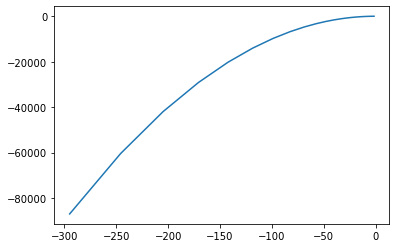

In [106]:
x
plt.plot(x, fx)

In [111]:
from RBM_AA.cgbrbm_torch import CGBRBM_pl
from data.transform import Binning, NeuralFP, NormalizeTarget

data = Zinc_mod(root="data/Zinc/",
               transform=NormalizeTarget("models/zinc_logP_std_scaler.pkl")
               #Binning("models/zinc_bins_freq_10.npz")
               )
loader = Zinc_loader(data, subset=True, batch_size=1000)
print("\n### Data loading complete ###\n")

transform = NeuralFP("checkpoints/fpnn/fpnn_large_v3.pt")

nvis = data[0].target.size(-1)
ncond = transform(data[0]).fp.size(-1)
nhid = 64

name = "cd"

rbm = CGBRBM_pl(transform, nvis=nvis, nhid=nhid, ncond=ncond,
              lr=0.01, momentum=1,
              mode=name,
              #sample=True
              )  




### Data loading complete ###



In [429]:
rbm = CGBRBM_pl(transform, nvis=nvis, nhid=nhid, ncond=ncond,
              lr=0.01, momentum=1,
              mode=name,
              #sample=True
              )


ckpt = torch.load(
            #"checkpoints/cgbrbm_cd/epoch=49-step=499-v2.ckpt"
             "checkpoints/cgbrbm_cd_v2/epoch=497-step=497.ckpt"
             )
rbm.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [177]:
point = 500

pred = rbm.rbm.predict_target(transform(data[point]).fp)
pred, data[point].target

(Parameter containing:
 tensor([[0.0208]], requires_grad=True),
 tensor([[0.5155]]))

In [178]:
data.transform.scaler.inverse_transform(pred.detach()), data[point].y[:,-1]

(array([[1.24687587]]), tensor([2.0490]))

In [179]:
r = torch.linspace(-3, 3, 200).float()
fes = []
fe_diffs = []
mses = []

for i in range(len(r)):
    fe, fe_diff, mse = rbm.rbm.compute_loss_metric(r[i:i+1].reshape(-1,1), transform(data[point]).fp)
    fes.append( fe.detach().item() )
    fe_diffs.append( fe_diff.detach().item() )
    mses.append( mse.detach().item() )

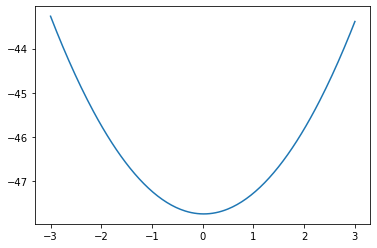

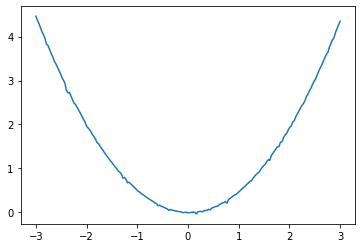

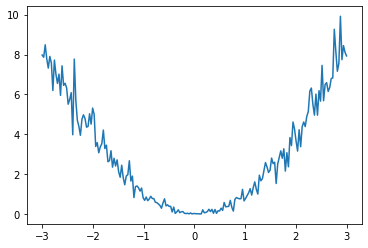

In [180]:
plt.plot(r, fes)
plt.show()
plt.plot(r, fe_diffs)
plt.show()
plt.plot(r, mses)
plt.show()

In [176]:
rbm.rbm.b

Parameter containing:
tensor([[-0.0060]], requires_grad=True)

In [187]:
actual = []
predicted = []
for point in range(len(test_targets)):
    pred = rbm.rbm.predict_target(transform(data[point]).fp)
    predicted.append( pred.detach().item() )
    actual.append( data[point].target[0,-1].item() )

In [419]:
data = Zinc_mod(root="data/Zinc/",
               transform=NormalizeTarget("models/zinc_logP_std_scaler.pkl")
               #Binning("models/zinc_bins_freq_10.npz")
               )
loader = Zinc_loader(data, subset=True, batch_size=20)

In [432]:
train_errors = []
for batch in loader.train_dataloader():
    batch = transform(batch)
    actual_targets = batch.target
    predicted_targets = rbm.rbm.predict_target(batch.fp, lazy=True)
    train_errors.append( torch.nn.MSELoss()(actual_targets, predicted_targets) .detach().numpy() )
    print("#",end="")
    
np.mean(train_errors)


Exception ignored in: <function _releaseLock at 0x7fc86f3bb1f0>
Traceback (most recent call last):
  File "/home/akshay/miniforge3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


0.43583113

In [430]:
val_errors = []
for batch in loader.val_dataloader():
    batch = transform(batch)
    actual_targets = batch.target
    predicted_targets = rbm.rbm.predict_target(batch.fp, lazy=True)
    val_errors.append( torch.nn.MSELoss()(actual_targets, predicted_targets) .detach().numpy() )
    print("#",end="")

np.mean(val_errors)


##################################################

0.41996586

In [431]:
test_errors = []
for batch in loader.test_dataloader():
    batch = transform(batch)
    actual_targets = batch.target
    predicted_targets = rbm.rbm.predict_target(batch.fp, lazy=True)
    test_errors.append( torch.nn.MSELoss()(actual_targets, predicted_targets) .detach().numpy() )
    print("#",end="")

np.mean(test_errors)

##################################################

0.39692524

In [434]:
rbm_models = ["epoch=99-step=999.ckpt", "epoch=497-step=497.ckpt"]
train_metrics = [0.39017856, 0.43583113]
val_metrics = [0.38205722, 0.41996586]
test_metrics = [0.3574412, 0.39692524]

In [437]:
d = test_metrics
np.mean(d), np.std(d)

(0.37718322000000004, 0.01974202)

In [438]:
import pandas as pd

In [443]:
cd_train = pd.read_csv("logs/cd_train.csv").values[:,1]
cd_val = pd.read_csv("logs/cd_val.csv").values[:,1]
qs_train = pd.read_csv("logs/qs_temp.csv").values[:,1]
qs_val = pd.read_csv("logs/qs_val_temp.csv").values[:,1]

Text(0.5, 1.0, 'Training')

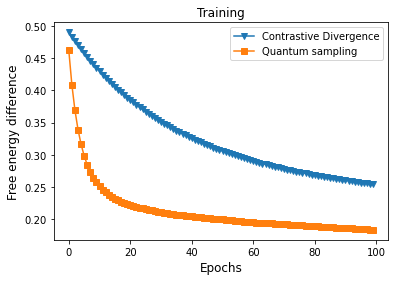

In [455]:
plt.plot(cd_train, label="Contrastive Divergence", marker="v")
plt.plot(qs_train, label="Quantum sampling", marker="s")
plt.legend()
plt.xlabel("Epochs", size=12)
plt.ylabel("Free energy difference", size=12)
plt.title("Training")

Text(0.5, 1.0, 'Validation')

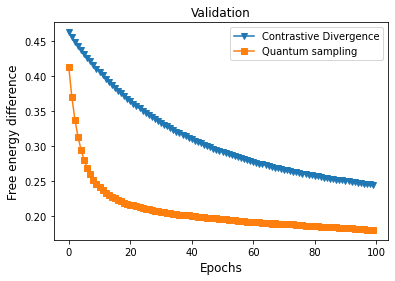

In [456]:
plt.plot(cd_val, label="Contrastive Divergence", marker="v")
plt.plot(qs_val, label="Quantum sampling", marker="s")
plt.legend()
plt.xlabel("Epochs", size=12)
plt.ylabel("Free energy difference", size=12)
plt.title("Validation")

In [262]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [221]:
c = Chem.MolFromSmiles("C")
o = Chem.MolFromSmiles("O")
n = Chem.MolFromSmiles("N")
f = Chem.MolFromSmiles("F")
s = Chem.MolFromSmiles("S")
cl = Chem.MolFromSmiles("Cl")
br = Chem.MolFromSmiles("Br")
i = Chem.MolFromSmiles("I")
p = Chem.MolFromSmiles("P")

In [232]:
p.GetNumAtoms()

1

In [234]:
co = Chem.RWMol(Chem.rdmolops.CombineMols(c, o))

In [236]:
atoms = co.GetAtoms()

In [237]:
for idx, atm in enumerate(atoms):
    print(idx, atm, atm.GetAtomMapNum())

0 <rdkit.Chem.rdchem.Atom object at 0x7fc5e215adc0> 0
1 <rdkit.Chem.rdchem.Atom object at 0x7fc5e215aa60> 0


In [239]:
co.GetAtomWithIdx(1).GetSymbol()

'O'

In [252]:
co2 = Chem.CombineMols(c, o)
co2 = Chem.RemoveHs(co2)

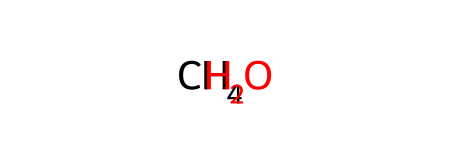

In [253]:
co2

In [254]:
co2e = Chem.EditableMol(co2)
co2e.AddBond(0,1,order=Chem.rdchem.BondType.DOUBLE)
co2e

In [255]:
co2e.AddBond(0,1,order=Chem.rdchem.BondType.DOUBLE)

1

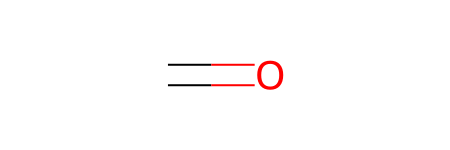

In [265]:
comb = co2e.GetMol()
chem = Chem.RemoveHs(comb)
chem

In [248]:
Chem.rdchem.BondType.SINGLE

rdkit.Chem.rdchem.BondType.SINGLE

In [263]:
AllChem.EmbedMolecule(comb)

RDKit WARNING: [20:10:02] Molecule does not have explicit Hs. Consider calling AddHs()
[20:10:02] Molecule does not have explicit Hs. Consider calling AddHs()


0

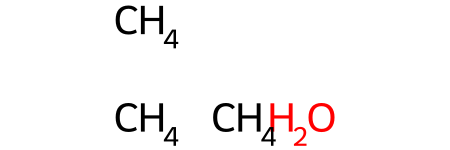

In [317]:
m = Chem.MolFromSmiles("C")
m = Chem.CombineMols(m, o)

for _ in range(2):
    m = Chem.CombineMols(m, c)

m

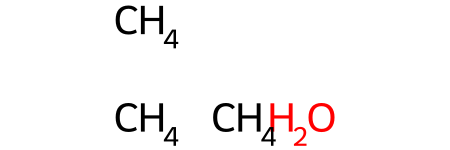

In [283]:
m = AllChem.RemoveHs(m)
m

In [277]:
atoms = m.GetAtoms()

In [278]:
for idx, atm in enumerate(atoms):
    print( m.GetAtomWithIdx(idx).GetSymbol() )

C
O
C
C


In [279]:
torch.argmax( data[0].x, dim=1 )

tensor([0, 0, 2, 0, 0, 4, 0, 0, 1, 2, 0, 0, 0, 0, 0, 3, 3, 3])

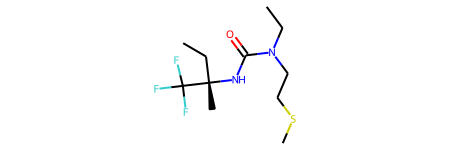

In [280]:
data[0].mol

In [287]:
a = np.zeros((4,4))
a[1,2] = 1
a[1,3] = 1
a[3,1] = 1

In [297]:
np.where(a == 1)
#np.concatenate(np.where(a == 1), axis=1)

(array([1, 1, 3]), array([2, 3, 1]))

In [314]:
int(np.)

1

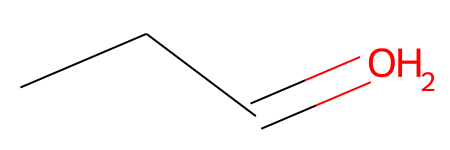

In [318]:
m = Chem.EditableMol(m)
m.AddBond(0,int(np.int64(1)),order=Chem.rdchem.BondType.DOUBLE)
m.AddBond(0,2,order=Chem.rdchem.BondType.SINGLE)
m.AddBond(2,3,order=Chem.rdchem.BondType.SINGLE)
#m.AddBond(2,0,order=Chem.rdchem.BondType.SINGLE)

m = m.GetMol()
m

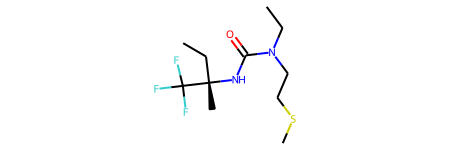

In [298]:
data[0].mol

In [302]:
X = data[0].x.numpy()
ei = data[0].edge_index.numpy()
A = np.zeros((len(X), len(X)))
A[ei[0,:], ei[1,:]] = 1


In [339]:
from mol_design.utils import *

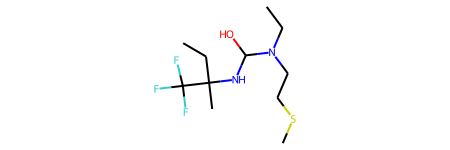

In [340]:
mol = data_to_mol(X, A)
mol

array([ 1,  0,  2,  1,  3,  7,  2,  4,  3,  5,  4,  6,  5,  2,  8,  9,  7,
        7, 10,  9, 11, 12, 14, 10, 10, 13, 12, 10, 15, 16, 17, 14, 14, 14])

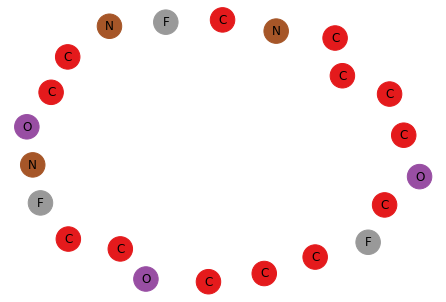

In [465]:
point = 500
A = np.zeros((data[point].x.shape))
ng = data_to_nx(data[point].x, A)
draw_nx_graph(ng)

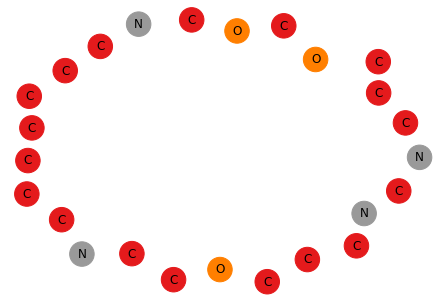

In [472]:
ng = data_to_nx(data[1].x, A)
draw_nx_graph(ng, pos = nx.spring_layout(ng))

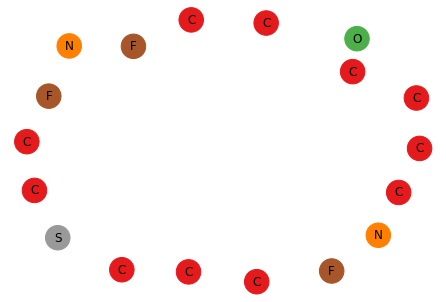

In [557]:
point = 0
required_target = data[point].target

A = np.zeros((data[point].x.shape))
ng = data_to_nx(data[point].x, A)
draw_nx_graph(ng, pos = nx.spring_layout(ng))

In [556]:
nx.get_node_attributes(ng, 'atom_symbol')

{0: 'C',
 1: 'C',
 2: 'C',
 3: 'C',
 4: 'N',
 5: 'C',
 6: 'O',
 7: 'N',
 8: 'C',
 9: 'C',
 10: 'C',
 11: 'C',
 12: 'C',
 13: 'C',
 14: 'C',
 15: 'C',
 16: 'N',
 17: 'N',
 18: 'C',
 19: 'C',
 20: 'C',
 21: 'C',
 22: 'O',
 23: 'C',
 24: 'O'}

In [522]:
def target_function(**kwargs):
    graph = data[point]
    nodes = graph.x.size(0)
    A = np.zeros((nodes, nodes))
    for i in range(nodes):
        for j in range(i+1, nodes):
            A[i,j] = round(kwargs[f"a_{i}_{j}"])
            A[j,i] = round(kwargs[f"a_{i}_{j}"])
    row, col = np.where(A==1)
    edge_index = np.array([row, col])
    edge_index = torch.from_numpy(edge_index).to(torch.int64)
    graph.edge_index = edge_index
    graph = transform(graph)
    fe = rbm.rbm.free_energy_v2(required_target, graph.fp)
    return -fe.detach().numpy()

def var_to_array(param):
    graph = data[point]
    nodes = graph.x.size(0)
    A = np.zeros((nodes, nodes))
    for i in range(nodes):
        for j in range(i+1, nodes):
            A[i,j] = round(param[f"a_{i}_{j}"])
    return A


In [523]:
from mol_design.bayes import BayesOpt

In [524]:
opt = BayesOpt(data[point].x, target_function, "max")

In [525]:
opt.optimize()

|   iter    |  target   |   a_0_0   |   a_0_1   |  a_0_10   |  a_0_11   |  a_0_12   |  a_0_13   |  a_0_14   |  a_0_15   |  a_0_16   |  a_0_17   |   a_0_2   |   a_0_3   |   a_0_4   |   a_0_5   |   a_0_6   |   a_0_7   |   a_0_8   |   a_0_9   |  a_10_0   |  a_10_1   |  a_10_10  |  a_10_11  |  a_10_12  |  a_10_13  |  a_10_14  |  a_10_15  |  a_10_16  |  a_10_17  |  a_10_2   |  a_10_3   |  a_10_4   |  a_10_5   |  a_10_6   |  a_10_7   |  a_10_8   |  a_10_9   |  a_11_0   |  a_11_1   |  a_11_10  |  a_11_11  |  a_11_12  |  a_11_13  |  a_11_14  |  a_11_15  |  a_11_16  |  a_11_17  |  a_11_2   |  a_11_3   |  a_11_4   |  a_11_5   |  a_11_6   |  a_11_7   |  a_11_8   |  a_11_9   |  a_12_0   |  a_12_1   |  a_12_10  |  a_12_11  |  a_12_12  |  a_12_13  |  a_12_14  |  a_12_15  |  a_12_16  |  a_12_17  |  a_12_2   |  a_12_3   |  a_12_4   |  a_12_5   |  a_12_6   |  a_12_7   |  a_12_8   |  a_12_9   |  a_13_0   |  a_13_1   |  a_13_10  |  a_13_11  |  a_13_12  |  a_13_13  |  a_13_14  |  a_13_15  |  a_13_16  |  a

In [526]:
hist = opt.hist

In [ ]:
from mol_design.utils import 

In [541]:
A_hist = [var_to_array(i["params"]) for i in hist]
mol_hist, fe_hist = [], []

for i, a in enumerate(A_hist):
    try:
        mol = data_to_mol(data[point].x, a)
        mol_hist.append( mol )
        fe_hist.append( hist[i]["target"] )
    except:
        print("Rdkit error")

Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error
Rdkit error


RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 10, is greater than permitted
[13:02:30] Explicit valence for atom # 0 C, 10, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 10, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:02:30] Explicit valence for atom # 0 C, 10, is greater than permitted
[13:02:30] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 11, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 7, is greater than permitted
[13:02:30] Explicit valence for atom # 0 C, 11, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[13:02:30] Explicit valence for atom # 0 C, 7, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 0 C, 9, is greater than permitted
[13:02:30] Explicit valence

In [542]:
len(mol_hist)

0

In [540]:
len(A_hist)

30

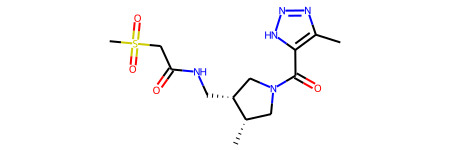

In [599]:
point = 105
data[point].mol

In [600]:
data[point].y

tensor([[343.4090,   0.0000,  -1.0180]])

In [601]:
data[point].x.sum(dim=0)

tensor([13.,  4.,  5.,  0.,  1.,  0.,  0.,  0.,  0.])

In [602]:
A = np.zeros((len(data[point].x), len(data[point].x)))

row, col = data[point].edge_index

for i,j in zip(row,col):
    A[i,j] = 1

A

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0.,

In [565]:
row, col = np.where(A==1)

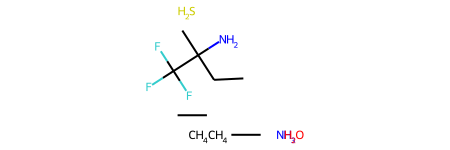

In [575]:
A_c = np.zeros((len(data[point].x), len(data[point].x)))
A_c[row, col] = 1

ra = np.random.randint(0, 18, size=25)
for i in ra:
    A_c[row[i], col[i]] = 0

data_to_mol(data[point].x, A_c)

In [570]:
ra

array([18,  8,  7, 12, 17,  5,  1, 10,  3])

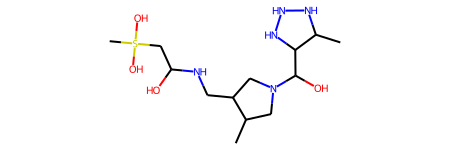

In [603]:
data_to_mol(data[point].x, A)

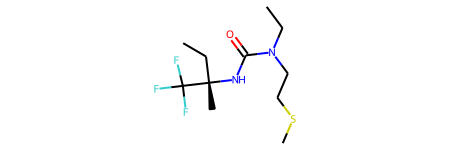

In [554]:
data_to_mol(data[point].x, A_c)

Text(0.5, 0, 'Iteration')

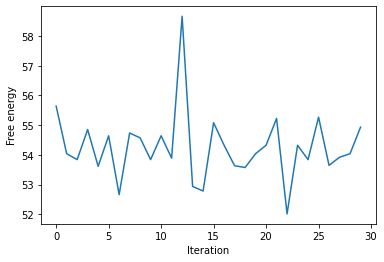

In [559]:
plt.plot([i["target"] for i in hist])
plt.ylabel("Free energy")
plt.xlabel("Iteration")


In [614]:
from mol_design.utils import edge_matrix_validity

In [615]:
x1 = data[0].x
r,c = data[0].edge_index.numpy()

In [616]:
A = np.zeros((x1.shape[0], x1.shape[0]))
for i,j in zip(r,c):
    A[i,j] = 1

In [619]:
edge_matrix_validity(x1, A)

(1,
 0,
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True])

In [633]:
x1.argmax(1)

tensor([0, 0, 2, 0, 0, 4, 0, 0, 1, 2, 0, 0, 0, 0, 0, 3, 3, 3])

In [628]:
A[8]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [653]:
A[8, 0] = 1
A[8, 2] = 1
A[0, 8] = 1
A[2, 8] = 1

In [630]:
A[8]

array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [654]:
a,b,c,d = edge_matrix_validity(x1, A)

C 4 2.0
C 4 2.0
N 3 4.0
C 4 2.0
C 4 2.0
S 2 2.0
C 4 1.0
C 4 3.0
O 2 3.0
N 3 2.0
C 4 4.0
C 4 1.0
C 4 2.0
C 4 1.0
C 4 4.0
F 1 1.0
F 1 1.0
F 1 1.0


In [655]:
a,b,c,d

(0,
 2,
 [True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 ['C',
  'C',
  'N',
  'C',
  'C',
  'S',
  'C',
  'C',
  'O',
  'N',
  'C',
  'C',
  'C',
  'C',
  'C',
  'F',
  'F',
  'F'])

In [642]:
np.sum(A, 1)

array([1., 2., 3., 2., 2., 2., 1., 3., 3., 2., 4., 1., 2., 1., 4., 1., 1.,
       1.])

In [656]:
from mol_design.qubo_opt import *

In [649]:
np.sum(A, axis=1)[8]

3.0

In [659]:
def target_function():
    pass

In [660]:
opt = QuboOPT(x1, target_func=target_function)

In [661]:
res = opt.sample(random=True, valid=True)

In [669]:
for sam in res.samples():
    print(sam)

{(0, 1): 1, (0, 2): 1, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (1, 2): 0, (1, 3): 1, (1, 4): 0, (1, 5): 0, (1, 6): 1, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 0, (2, 10): 0, (2, 11): 0, (2, 12): 1, (2, 13): 0, (2, 14): 0, (2, 15): 0, (2, 16): 0, (2, 17): 0, (3, 4): 1, (3, 5): 1, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0, (3, 13): 0, (3, 14): 0, (3, 15): 0, (3, 16): 0, (3, 17): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (4, 8): 1, (4, 9): 1, (4, 10): 0, (4, 11): 0, (4, 12): 0, (4, 13): 0, (4, 14): 0, (4, 15): 0, (4, 16): 0, (4, 17): 0, (5, 6): 0, (5, 7): 1, (5, 8): 0, (5, 9): 0, (5, 10): 0, (5, 11): 0, (5, 12): 0, (5, 13): 0, (5, 14): 0, (5, 15): 0, (5, 16): 0, (5, 17

In [668]:
sam

{(0, 1): 1, (0, 2): 1, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (1, 2): 0, (1, 3): 1, (1, 4): 0, (1, 5): 0, (1, 6): 1, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 0, (2, 10): 0, (2, 11): 0, (2, 12): 1, (2, 13): 0, (2, 14): 0, (2, 15): 0, (2, 16): 0, (2, 17): 0, (3, 4): 1, (3, 5): 1, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0, (3, 13): 0, (3, 14): 0, (3, 15): 0, (3, 16): 0, (3, 17): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (4, 8): 1, (4, 9): 1, (4, 10): 0, (4, 11): 0, (4, 12): 0, (4, 13): 0, (4, 14): 0, (4, 15): 0, (4, 16): 0, (4, 17): 0, (5, 6): 0, (5, 7): 1, (5, 8): 0, (5, 9): 0, (5, 10): 0, (5, 11): 0, (5, 12): 0, (5, 13): 0, (5, 14): 0, (5, 15): 0, (5, 16): 0, (5, 17

In [1]:
import pandas as pd

In [2]:
d = pd.read_csv("data/Zinc/raw/250k_rndm_zinc_drugs_clean_3.csv")

In [7]:
for i, a in d.iterrows():
    break

In [12]:
a["smiles"].rstrip()

'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1'

In [17]:
a["SAS"]

2.0840945720726807

In [20]:
d.values

array([['CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\r\n', 5.0506,
        0.702012232801, 2.0840945720726807],
       ['C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\r\n', 3.1137,
        0.928975488089, 3.4320038192747795],
       ['N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1\r\n',
        4.96778, 0.599681738168, 2.4706326078252],
       ...,
       ['Cc1ccc(NC(=O)C(=O)N(C)Cc2ccccc2)c(C)c1\r\n', 2.9005400000000003,
        0.878086009481, 1.8406421465940688],
       ['Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1\r\n',
        2.5562400000000003, 0.852917144772, 2.0246383983956133],
       ['O=C(CC(c1ccccc1)c1ccccc1)N1CCN(S(=O)(=O)c2ccccc2[N+](=O)[O-])CC1\r\n',
        3.6499, 0.370286586827, 2.2142492922644124]], dtype=object)

In [1]:
from data.Zinc_torch import Zinc_mod, Zinc_loader

In [2]:
data = Zinc_mod("data/Zinc")

Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index


In [6]:
lp = []
sas = []

for i in data:
    lp.append(i.y[0, -1])
    sas.append(i.y[0, -2])

In [9]:
np.min(lp), np.max(lp)

(-6.8762, 8.2521)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
div = [[], [], [], [], [], [], [], []]

In [25]:
for i, val in enumerate(lp):
    idx = int( (val.item()+6) / 2 )
    div[idx].append( sas[i].item() )


In [23]:
loader = 

7

In [15]:
div[0]

[]

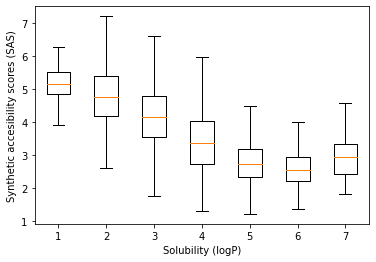

In [34]:
fig = plt.boxplot(div[:-1], showfliers=False)
plt.xlabel("Solubility (logP)")
plt.ylabel("Synthetic accesibility scores (SAS)")
plt.show()

In [4]:
loader = Zinc_loader(data, subset=True, batch_size=1)

In [185]:
x, y, z = [], [], []

for idx, i in enumerate(loader.train_dataloader()):
    x.append( i.y[:,-1].item() )
    y.append( i.y[:,-2].item() )
    z.append( i.x.size(0) )
    if idx >= 1000:
        break

# x = [i.y[:,-1].item() for i in loader.train_dataloader()] #log
# y = [i.y[:,-2].item() for i in loader.test_dataloader()] #sas
# z = [i.x.size(0) for  i in loader.test_dataloader()]

In [ ]:
for i in loader.test_dataloader():
    break

In [ ]:
i.x.size()

torch.Size([16, 9])

In [ ]:
import seaborn as sns

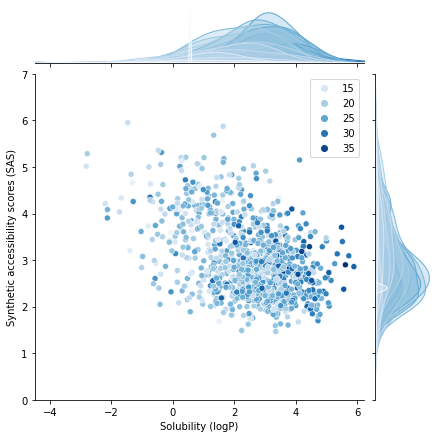

In [186]:
#fig, scatter = plt.subplots(figsize = (10,6), dpi = 100)
g = sns.jointplot(x=x, y=y, hue=z, xlim=[-4.5, 6.2], ylim=[0, 7], palette="Blues")
g.set_axis_labels(xlabel="Solubility (logP)", ylabel="Synthetic accessibility scores (SAS)")
#plt.legend(title="Num. atoms")
#plt.show(g)
#plt.xlabel("Solubility (logP)")
#g._legend.remove()

In [181]:
g.fig

AttributeError: 'JointGrid' object has no attribute 'axes'

In [ ]:
g.set_axis_labels(xlabel="Solubility (logP)", ylabel="Synthetic accessibility scores (SAS)")

In [3]:
from models.prop import Prop_v3
from data.transform import NeuralFP

In [8]:
transform = NeuralFP("checkpoints/fpnn/fpnn_large_v3.pt")

num_targets = 2

data = Zinc_mod(
                root="data/Zinc/", 
                transform=NormalizeTarget(
                              "models/zinc_std_scaler_qed_sas_logp.pkl", 
                              num_targets=num_targets
                              )
               )        ####### changed

loader = Zinc_loader(data, subset=True, batch_size=10_000)
print("\n### Data loading complete ###\n")


# Load model with fingerprints
input_size = transform(data[0]).fp.size(-1)
#print(f"{name} fingerprint size : {input_size}")




Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index



### Data loading complete ###



In [13]:
loss = "mse"

prop = Prop_v3(transform=transform, input_size=input_size, loss=loss, num_targets=num_targets)

In [27]:
import torch
import torch.nn.functional as F
import numpy as np

In [15]:
ckpt = torch.load("checkpoints/prop/neural/v4/epoch=24-step=24.ckpt")
prop.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [125]:
from mol_design.utils import xA_to_graph

In [22]:
idx = 0

target = data[idx].y[:,-1:] # logP 
x = data[idx].x

def target_func(x, A):
    graph = xA_to_graph(x, A)
    pred = prop(graph)
    return F.l1_loss(pred[:,-1:], target[:,-1:])

In [21]:
from mol_design.qubo_opt import QuboOPT

In [78]:
opt = QuboOPT(x, target_func)

In [79]:
samples = []

In [126]:
for _ in range(10):
    A = opt.sample(valid=True, random=True, fully_connected=False)
    graph = xA_to_graph(x, A)
    samples.append(graph.mol)

In [74]:
from rdkit.Chem import AllChem, Draw

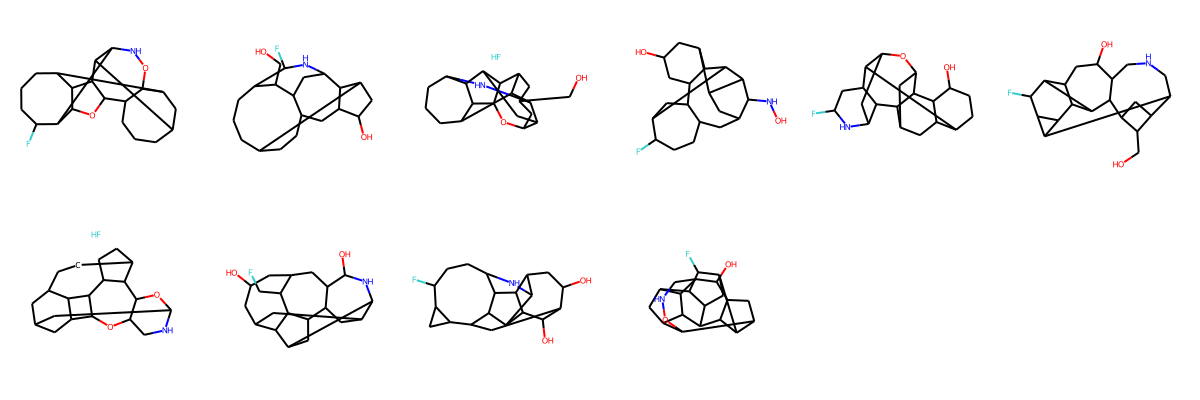

In [87]:

Draw.MolsToGridImage(samples, molsPerRow=6, #subImgSize=(400,250),
                    #legends=[str(i.y[:,-1].item()) for i in graphs])
)

In [83]:
from rdkit import Chem

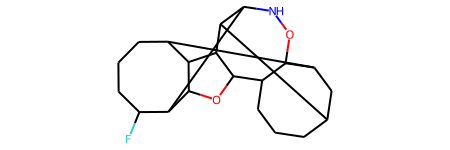

In [90]:
Chem.SanitizeMol(samples[0])
samples[0]

In [97]:
from mol_design.sasscorer import *

In [95]:
Chem.Kekulize(samples[0])
Chem.cleanupChirality

AttributeError: module 'rdkit.Chem' has no attribute 'cleanupChirality'

In [98]:
calculateScore( samples[0] )

7.203163315415427

In [99]:
data[idx].y

tensor([[0.7020, 2.0841, 5.0506]])

In [118]:
mol = data[idx].mol
calculateScore(mol), Crippen.MolLogP(mol)

(2.084094572072681, 5.050600000000004)

In [101]:
from rdkit.Chem import Crippen

In [103]:
logP

5.050600000000004

In [113]:
pred = prop(graph).detach().numpy()
pred = np.concatenate([[0], pred.ravel()]).reshape(-1,3)

In [116]:
data.transform.scaler.inverse_transform(pred)

array([[0.72744377, 3.0435068 , 2.48686883]])

In [119]:
mol = graph.mol
calculateScore(mol), Crippen.MolLogP(mol)

(7.483353651316572, 2.5580000000000007)

In [132]:
graph.

In [124]:
Chem.MolToSmiles(data[0].mol)

'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1'

In [137]:
m = Chem.MolFromSmiles(graph.smiles, sanitize=True)

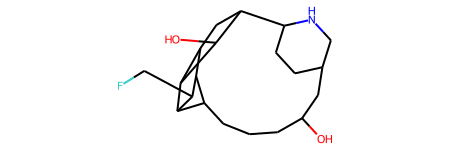

In [138]:
m

In [145]:
data[242].name

'C[C@@H]([C@@H](O)c1ccc2ncnn2c1)[N+](=O)[O-]'

In [9]:
for b in loader.test_dataloader():
    break

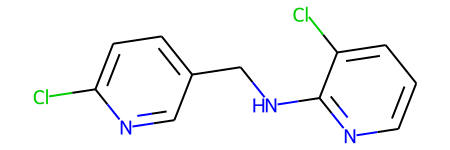

In [147]:
b[0].mol

In [152]:
data_to_mol

<function mol_design.utils.data_to_mol(X, A, E=None)>

In [8]:
from mol_design.utils import *

In [10]:
mols = [b[i] for i in range(500)]

In [11]:
xs = [i.x for i in mols]
As = [edges_to_matrix(i.edge_index, i.x.size(0)) for i in mols]

In [12]:
m2 = [xA_to_graph(xs[i], As[i]) for i in range(500)]

In [14]:
m2_mol = [i.mol for i in m2]
labels = [f"{i.name} \n logP : {i.prop['logP']}" for i in m2]
sols = [i.prop['logP'] for i in m2]
sas = [i.prop['sas'] for i in m2]

In [15]:
import numpy as np

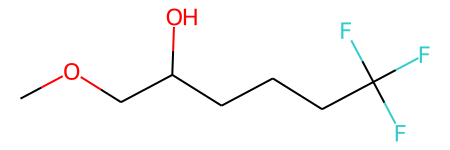

In [19]:
m2_mol[ np.argmin(sas) ]

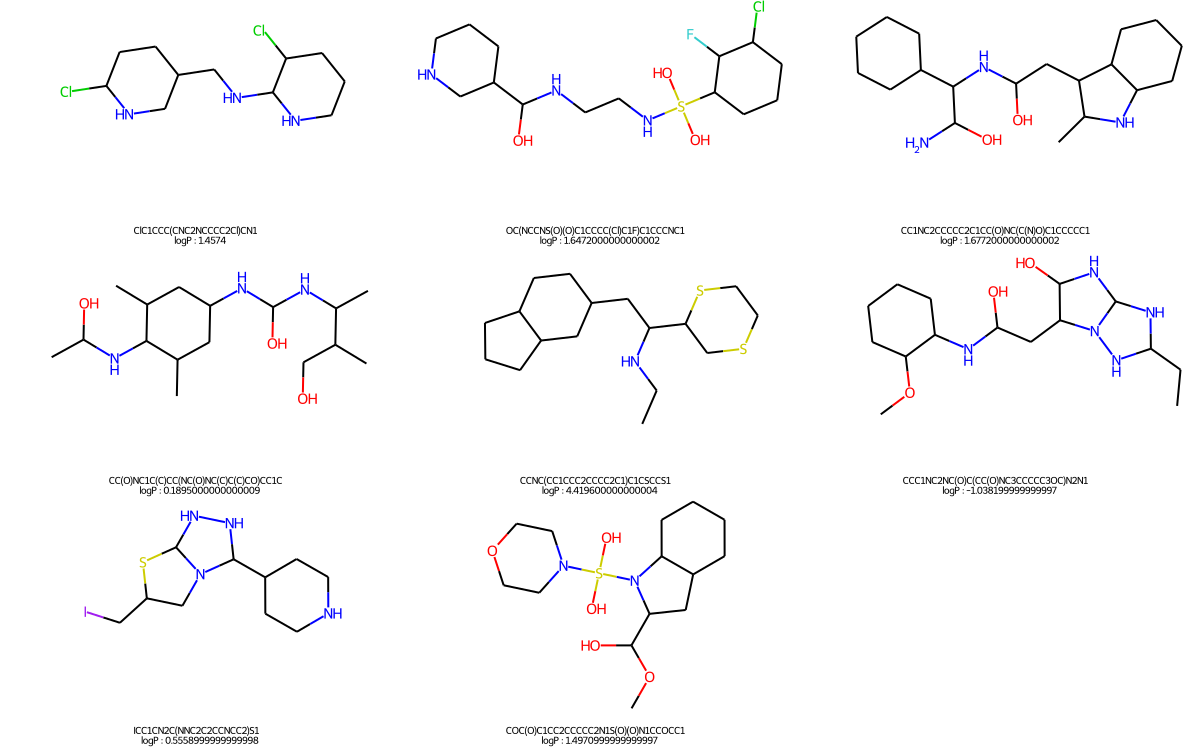

In [166]:
from rdkit.Chem import AllChem, Draw
Draw.MolsToGridImage(m2_mol, molsPerRow=3, subImgSize=(400,250),
                    legends=labels)

In [20]:
data[0]

AttributeError: 'NormalizeTarget' object has no attribute 'transform'

In [522]:
from models.fp import FPNN_v2, FPNN_v3

In [523]:
import torch
import pytorch_lightning as pl
import pickle
import torch.nn.functional as F
import torch.nn as nn

from RBM_AA.cgbrbm_torch import CGBRBM_pl

from data.transform import Binning, NeuralFP, NormalizeTarget

In [524]:
from data.Zinc_torch import Zinc_mod, Zinc_loader

target_names = {0:"qed", 1:"sas", 2:"logP"}
target_idx = [0,1,2] # 0:qed, 1:sas, 2:logP

data = Zinc_mod(root="data/Zinc/",
               transform=NormalizeTarget(
                              "models/zinc_std_scaler_qed_sas_logp.pkl", 
                              target_idx=target_idx,
                              transform = True  ### False does not apply transform only num_targets
                              )
               )
loader = Zinc_loader(data, subset=True, batch_size=10_000)
print("\n### Data loading complete ###\n")

Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index



### Data loading complete ###



In [552]:
class CM(nn.Module):
    def __init__(self):
        super().__init__()
        self.fp = FPNN_v3(9, out_channels=256, dense_size=512)
        self.linear = nn.Linear(256, 3)
    
    def forward(self, x):
        x = self.fp(x)
        x = self.linear(x)
        return x

In [566]:
def scale_weights(model, scale):
    for param in model.parameters():
        param.data *= scale

# Define continous tanimoto similarity
def tanimoto(fp1,fp2):
    # num = sum(min(fp1[i], fp2[i]) for i in range(len(fp1)))
    # den = sum(max(fp1[i], fp2[i]) for i in range(len(fp1)))
    # return 1 - num/den
    c = np.dot(fp1, fp2)
    a = sum(fp1 ** 2)
    b = sum(fp2 * 2)
    return c / (a+b-c)

def tanimoto_binary(a, b):
    Na = sum(a) # On items
    Nb = sum(b)
    Nc = np.dot(a, b) # Common ONs
    return Nc / (Na+Nb-Nc)

In [554]:
cmodel = CM()
optim = torch.optim.Adam(cmodel.parameters())

In [555]:
for bt in loader.train_dataloader():
    break
for bv in loader.val_dataloader():
    break

In [556]:
for _ in range(100):
    optim.zero_grad()
    pred = cmodel(bt)
    loss = F.mse_loss(pred, bt.y)
    
    val_loss = F.mse_loss( cmodel(bv), bv.y )
    # update
    loss.backward()
    optim.step()

    print(f"EPoch {_}, loss {loss}, val_loss {val_loss}")



EPoch 0, loss 6.128589630126953, val_loss 6.180831432342529
EPoch 1, loss 6.026782512664795, val_loss 6.078620433807373
EPoch 2, loss 5.9262824058532715, val_loss 5.977720737457275
EPoch 3, loss 5.827108383178711, val_loss 5.878152370452881
EPoch 4, loss 5.729288578033447, val_loss 5.779943466186523
EPoch 5, loss 5.632843017578125, val_loss 5.683112144470215
EPoch 6, loss 5.537782669067383, val_loss 5.587669372558594
EPoch 7, loss 5.44411563873291, val_loss 5.493625164031982
EPoch 8, loss 5.351847171783447, val_loss 5.400984287261963
EPoch 9, loss 5.261000156402588, val_loss 5.309769630432129
EPoch 10, loss 5.171578884124756, val_loss 5.219984531402588
EPoch 11, loss 5.083591461181641, val_loss 5.13163948059082
EPoch 12, loss 4.997035026550293, val_loss 5.044729232788086
EPoch 13, loss 4.911910057067871, val_loss 4.959254741668701
EPoch 14, loss 4.828213691711426, val_loss 4.875214099884033
EPoch 15, loss 4.745940208435059, val_loss 4.792602062225342
EPoch 16, loss 4.665072917938232, v

In [557]:
F.l1_loss(cmodel(bv), bv.y, reduction="none").mean(dim=0)

tensor([0.1793, 1.1237, 1.1400], grad_fn=<MeanBackward1>)

In [585]:
scale_weights(cmodel.fp, 0.5) # 10, 5

In [602]:
neural = []
morgan = []

for i in loader.slices["test"]:
    neural.append( cmodel.fp(data[i]).detach().numpy().ravel() )
    morgan.append( tr_mor(data[i]).fp.numpy().ravel() )

In [603]:
neural_sim = []
morgan_sim = []
neural_sim2 = []

In [604]:

for i in range(len(neural)):
    for j in range(i+1, len(neural)):
        neural_sim2.append( tanimoto( neural[i], neural[j] ) )
        morgan_sim.append( tanimoto_binary( morgan[i], morgan[j] ) )

In [605]:
neural[0]

array([0.00745907, 0.00741415, 0.045904  , 0.0279935 , 0.00787546,
       0.04076759, 0.00931761, 0.00755258, 0.24920183, 0.01025084,
       0.04585257, 0.01026093, 0.01262334, 0.02408494, 0.02203391,
       0.00930957, 0.03688234, 0.02895518, 0.04331778, 0.14641047,
       0.01278089, 0.00974636, 0.00846872, 0.08811234, 0.11140749,
       0.00799634, 0.01376862, 0.00835139, 0.00674059, 0.00728684,
       0.01361923, 0.29805726, 0.00673271, 0.05440567, 0.08847449,
       0.13644238, 0.07024256, 0.03479436, 0.01381003, 0.00713489,
       0.03520371, 0.00880313, 0.0101091 , 0.03473682, 0.00746515,
       0.14116344, 0.08458391, 0.01590574, 0.00666068, 0.42432293,
       0.00811002, 0.02587097, 0.03892122, 0.01922787, 0.04956964,
       0.2318678 , 0.01116345, 0.01130417, 0.00867072, 0.44837838,
       0.23274246, 0.08454197, 0.06672535, 0.01494544, 0.00666068,
       0.00967981, 0.01570988, 0.01733895, 0.00776478, 0.00666068,
       0.01135002, 0.00703614, 0.0296727 , 0.00736727, 0.00666

In [571]:
idx = 0
neural_sim[0], neural_sim2[0]

IndexError: list index out of range

In [609]:
torch.save(cmodel.fp, "models/gnn_fp_continous_512.pt")

In [610]:
fp2 = torch.load("models/gnn_fp_continous_512.pt")

In [613]:
fp2(data[loader.slices["test"][1]])

tensor([[0.0119, 0.0123, 0.0644, 0.0399, 0.0121, 0.0514, 0.0358, 0.0182, 0.1665,
         0.0174, 0.1401, 0.0187, 0.0210, 0.0364, 0.0229, 0.0186, 0.0605, 0.0385,
         0.0938, 0.2134, 0.0179, 0.0157, 0.0129, 0.0949, 0.0992, 0.0124, 0.0514,
         0.0180, 0.0202, 0.0124, 0.0165, 0.3614, 0.0214, 0.0618, 0.1035, 0.1804,
         0.1349, 0.0400, 0.0705, 0.0137, 0.0615, 0.0162, 0.0214, 0.0696, 0.0197,
         0.1976, 0.1124, 0.0216, 0.0115, 0.5138, 0.0124, 0.0314, 0.0545, 0.0416,
         0.0605, 0.2970, 0.0160, 0.0190, 0.0149, 0.5911, 0.3164, 0.2633, 0.1179,
         0.0222, 0.0115, 0.0153, 0.0455, 0.0226, 0.0138, 0.0115, 0.0166, 0.0139,
         0.0307, 0.0120, 0.0136, 0.0152, 0.0417, 0.0115, 0.0119, 0.0500, 0.0270,
         0.0145, 0.0321, 0.0337, 0.0119, 0.0257, 0.0115, 0.0624, 0.0450, 0.0144,
         0.0549, 0.0125, 0.3673, 0.0249, 0.0170, 0.0171, 0.0403, 0.0154, 0.0378,
         0.2864, 0.0384, 0.5385, 0.0160, 0.0165, 0.0431, 0.3067, 0.0744, 0.0429,
         0.0138, 0.1990, 0.3

In [615]:
neural[1]

array([0.01191998, 0.01226992, 0.06436564, 0.03986505, 0.01208004,
       0.0514294 , 0.03577689, 0.01819905, 0.16645841, 0.01738799,
       0.14009637, 0.01870821, 0.02097591, 0.0364413 , 0.02294705,
       0.01858032, 0.0605083 , 0.03848162, 0.09378188, 0.21336956,
       0.01788977, 0.01566876, 0.01292299, 0.09491085, 0.09923675,
       0.0124226 , 0.05141576, 0.01798883, 0.02018804, 0.01244054,
       0.01651083, 0.36142626, 0.02136174, 0.06183293, 0.10346095,
       0.18041869, 0.13489217, 0.04003431, 0.07045123, 0.0136841 ,
       0.06151254, 0.0162143 , 0.02136594, 0.06960282, 0.01972054,
       0.19764064, 0.11239564, 0.02157653, 0.0115194 , 0.51376027,
       0.01237802, 0.03140522, 0.05450493, 0.04156606, 0.06054954,
       0.2970307 , 0.01602058, 0.01895148, 0.01489245, 0.5911334 ,
       0.3163554 , 0.26333675, 0.11792517, 0.02221572, 0.0115194 ,
       0.01529331, 0.04551169, 0.02261248, 0.01383309, 0.0115194 ,
       0.01658989, 0.0139409 , 0.03067359, 0.01199046, 0.01356

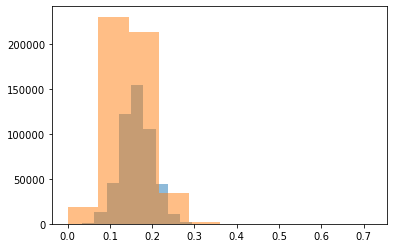

In [601]:
plt.hist(neural_sim2, alpha = 0.5)
plt.hist(morgan_sim, alpha = 0.5)
plt.show()

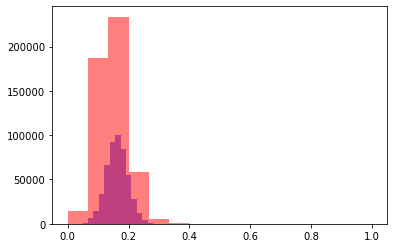

In [608]:
plt.hist(neural_sim2, bins=15, alpha = 0.5, color= 'b')
plt.hist(morgan_sim, bins=15, alpha = 0.5, color= 'r')
plt.show()

(array([1.86950e+04, 2.30586e+05, 2.13538e+05, 3.38290e+04, 2.53200e+03,
        2.54000e+02, 5.50000e+01, 8.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([0.   , 0.072, 0.144, 0.216, 0.288, 0.36 , 0.432, 0.504, 0.576,
        0.648, 0.72 ]),
 <BarContainer object of 10 artists>)

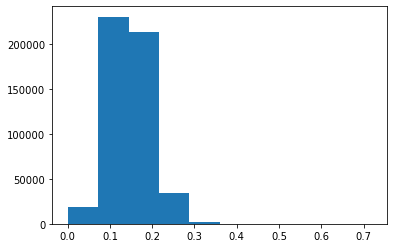

In [591]:
plt.hist(morgan_sim)

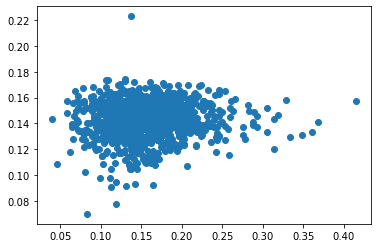

In [592]:
idx = 1000

plt.scatter(morgan_sim[:idx], neural_sim2[:idx])

In [595]:
from scipy.stats import linregress

In [597]:
res = linregress(morgan_sim, neural_sim2)

In [599]:
res.rvalue ** 2

0.08047717902995384

In [278]:
model = torch.load("checkpoints/fpnn/fpnn_large_v3.pt")

In [282]:
from data.transform import NeuralFP, MorganFP, MaccsFP, NormalizeTarget

In [297]:
neural = []
morgan = []
maccs = []

In [283]:
tr_mor = MorganFP()
tr_mac = MaccsFP()
tr_neural = NeuralFP("checkpoints/fpnn/fpnn_large_v3.pt")

In [298]:
for i in loader.slices["val"]:
    neural.append( tr_neural(data[i]).fp.numpy().ravel() )
    morgan.append( tr_mor(data[i]).fp.numpy().ravel() )
    maccs.append( tr_mac(data[i]).fp.numpy().ravel() )

In [287]:
def tanimoto_binary(a, b):
    Na = sum(a) # On items
    Nb = sum(b)
    Nc = np.dot(a, b) # Common ONs
    return Nc / (Na+Nb-Nc)

In [304]:
neural_sim = []
morgan_sim = []
maccs_sim = []


In [306]:

for i in range(len(neural)):
    for j in range(i+1, len(neural)):
        neural_sim.append( tanimoto_binary( neural[i], neural[j] ) )
        morgan_sim.append( tanimoto_binary( morgan[i], morgan[j] ) )
        maccs_sim.append( tanimoto_binary( maccs[i], maccs[j] ) )

In [325]:
neural_sim = np.array(neural_sim)
morgan_sim = np.array(morgan_sim)
maccs_sim = np.array(maccs_sim)

In [307]:
import matplotlib.pyplot as plt

(array([   389.,   2022.,  22214.,  69610., 136479., 106712., 115665.,
         33646.,  10998.,   1765.]),
 array([0.37634409, 0.43870968, 0.50107527, 0.56344086, 0.62580645,
        0.68817204, 0.75053763, 0.81290323, 0.87526882, 0.93763441,
        1.        ]),
 <BarContainer object of 10 artists>)

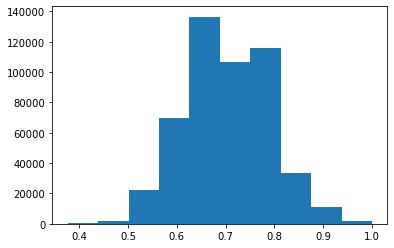

In [308]:
plt.hist(neural_sim)

(array([1.86950e+04, 2.30586e+05, 2.13538e+05, 3.38290e+04, 2.53200e+03,
        2.54000e+02, 5.50000e+01, 8.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([0.   , 0.072, 0.144, 0.216, 0.288, 0.36 , 0.432, 0.504, 0.576,
        0.648, 0.72 ]),
 <BarContainer object of 10 artists>)

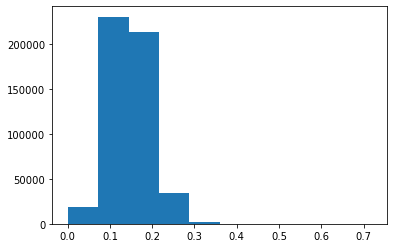

In [309]:
plt.hist(morgan_sim)

(array([1.59600e+03, 1.89410e+04, 7.56270e+04, 1.41726e+05, 1.40347e+05,
        8.43780e+04, 3.06180e+04, 5.70900e+03, 5.34000e+02, 2.40000e+01]),
 array([0.        , 0.09318182, 0.18636364, 0.27954545, 0.37272727,
        0.46590909, 0.55909091, 0.65227273, 0.74545455, 0.83863636,
        0.93181818]),
 <BarContainer object of 10 artists>)

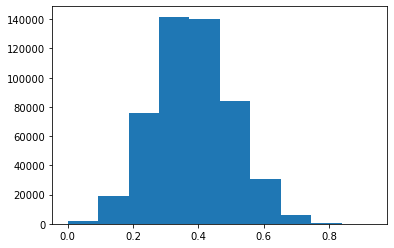

In [310]:
plt.hist(maccs_sim)

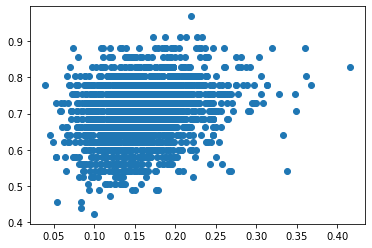

In [316]:
plt.scatter(morgan_sim[:2000], neural_sim[:2000])

In [318]:
import seaborn as sns
import numpy as np

/home/akshay/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


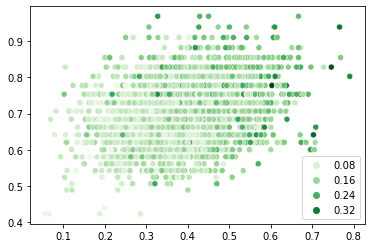

In [339]:
idx = np.random.randint(0, 499500, size=2500).tolist()
g = sns.scatterplot(maccs_sim[idx], neural_sim[idx], hue=morgan_sim[idx], 
                palette="Greens")

In [340]:
import scipy

In [342]:
a = scipy.stats.linregress(maccs_sim, neural_sim)

In [344]:
a.rvalue

0.3165316025892102

In [203]:
max_deg = 0

for i in loader.slices["val"]:
    edge_index = data[i].edge_index
    x = data[i].x
    deg = degree(edge_index[1 if fp.mf.flow == 'source_to_target' else 0],
                     x.size(0), dtype=torch.long)

    if deg.max() > max_deg:
        max_deg = deg.max()

In [204]:
max_deg

tensor(4)

In [208]:
fp(data[0])

AttributeError: 'MFConv_v2' object has no attribute 'root_weight'

In [345]:
from RBM_AA.cgbrbm_torch import CGBRBM_pl

In [366]:
loader = Zinc_loader(data, subset=True, batch_size=10_000)

transform = NeuralFP("checkpoints/fpnn/fpnn_large_v3.pt")

#### config
mode = "cd"

version = "v6_no_aux"
auxillary = False

name = f"{mode}_{target_names[target_idx[0]]}_{version}"


lr = 0.001
momentum = 1

#nvis = data[0].target.size(-1)      ##########previous
#ncond = transform(data[0]).fp.size(-1)

ncond = 1
nvis = transform(data[0]).fp.size(-1)

nhid = 64
#### config-end

In [367]:
rbm = CGBRBM_pl(transform, nvis=nvis, nhid=nhid, ncond=ncond,
              lr=lr, momentum=momentum,
              mode=mode,
              #sample=True
              auxillary=auxillary,
              vis_type = "binary" ######### was oreviously gaussian
              ) 

In [357]:
for batch in loader.test_dataloader():
    break

batch = transform(batch)

In [368]:
# load RBM

ckpt = torch.load("checkpoints/cgbrbm/cd/v6_no_aux/epoch=143-step=143.ckpt")
rbm.load_state_dict( ckpt["state_dict"] )

<All keys matched successfully>

In [370]:
means, samples = rbm.rbm.sample_h_given_vu(batch.fp, batch.target[:,-1:])

In [419]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib

In [452]:
samples = transform(batch).fp.numpy()

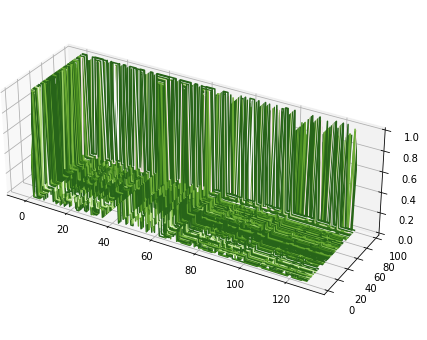

In [453]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
ax.pbaspect = [3,1,1]
cmap = plt.cm.get_cmap('PiYG')
norm = matplotlib.colors.Normalize(vmin=-4.1777, vmax=2.2914)

for i in range(100):
    z = samples[i]
    x = [i for i in range(len(z))]
    y = [i] * len(z)

    prop = batch[i].y[0, -1].item()
    
    ax.plot(x, y, z, c=cmap(norm(prop)))
    

In [447]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
res = pca.fit_transform(means)

props = batch.y[:,-2].numpy()

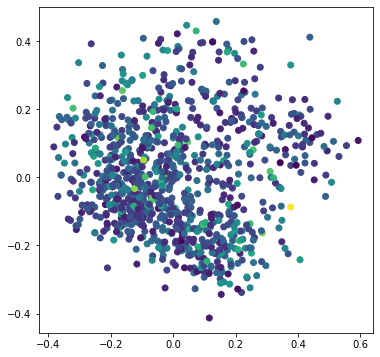

In [450]:
fig = plt.figure(figsize=[6,6])
#ax = fig.add_subplot(111, projection='3d')

plt.scatter(res[:,0], res[:,1],
            #res[:,2], 
            c=props)

In [1]:
import torch
import pytorch_lightning as pl
import pickle
import torch.nn.functional as F

from RBM_AA.cgbrbm_torch import CGBRBM_pl

from data.transform import Binning, NeuralFP, NormalizeTarget, NeuralFP_continous

target_names = {0:"qed", 1:"sas", 2:"logP"}
target_idx = 0 # 0:qed, 1:sas, 2:logP

# data = Zinc_mod(root="data/Zinc/",
#                transform=NormalizeTarget(
#                               "models/zinc_std_scaler_qed_sas_logp.pkl", 
#                               target_idx=target_idx,
#                               transform = True  ### False does not apply transform only num_targets
#                               )
#                )

target_transform = Binning("models/zinc_eq_freq_bins_10_qed_sas_logP.npz",
                           target_idx=target_idx
                           )

data = Zinc_mod(root="data/Zinc/",
               transform=target_transform
               )

loader = Zinc_loader(data, subset=True, batch_size=10_000)
print("\n### Data loading complete ###\n")

fp_transform = NeuralFP_continous("models/gnn_fp_continous_256.pt")

NameError: name 'Zinc_mod' is not defined

In [657]:
rbm = CGBRBM_pl(None, nvis=10, nhid=64, ncond=256,
              lr=None, momentum=None,
              mode="cd",
              #sample=True
              auxillary=True,
              vis_type = "binary" ######### was oreviously gaussian
              )  

In [658]:
ckpt = torch.load("checkpoints/cgbrbm/cd_qed_v1_aux_True/cute-flower-14/epoch=140-step=140.ckpt")

In [659]:
rbm.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [662]:
for bval in loader.val_dataloader():
    break

OSError: [Errno 12] Cannot allocate memory

In [663]:
ucond, vis = fp_transform(bval).fp, bt.label

_hmeans, _ = rbm.rbm.sample_h_given_vu(vis, ucond)

NameError: name 'bval' is not defined

In [636]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
res = pca.fit_transform(_hmeans)

props = bt.y[:,0].numpy()

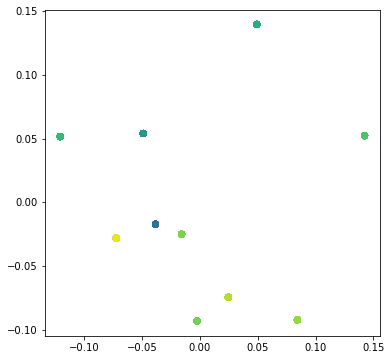

In [648]:
fig = plt.figure(figsize=[6,6])
#ax = fig.add_subplot(111, projection='3d')

plt.scatter(res[:,0], res[:,1],
            #res[:,2], 
            c=props)

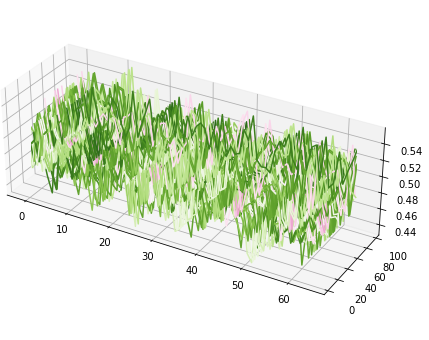

In [646]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
ax.pbaspect = [3,1,1]
cmap = plt.cm.get_cmap('PiYG')
norm = matplotlib.colors.Normalize(vmin=0.2071, vmax=0.9421)

for i in range(100):
    z = _hmeans[i]
    x = [i for i in range(len(z))]
    y = [i] * len(z)

    prop = bt[i].y[0, 0].item() # qed
    
    ax.plot(x, y, z, c=cmap(norm(prop)))

In [653]:
class TM(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(64, 1)

    def forward(x):
        return self.linear(x)


In [654]:
tmodel = TM()
optim = torch.optim.Adam(tmodel.parameters())

In [655]:
for btrain in loader.train_dataloader(): break
for bval in loader.val_dataloader(): break
for btest in loader.test_dataloader(): break

OSError: [Errno 12] Cannot allocate memory

In [500]:
targets = []

for i in data[loader.slices["train"]]:
    targets.append( i.y[0,:].numpy() )

for i in data[loader.slices["val"]]:
    targets.append( i.y[0,:].numpy() )

for i in data[loader.slices["test"]]:
    targets.append( i.y[0,:].numpy() )

In [513]:
targets = np.array(targets)
targets.shape

(12000, 3)

(array([   8.,   41.,  199.,  412.,  689., 1234., 1757., 2644., 3351.,
        1665.]),
 array([0.13865414, 0.21952836, 0.30040258, 0.3812768 , 0.462151  ,
        0.5430252 , 0.6238994 , 0.70477366, 0.78564787, 0.8665221 ,
        0.9473963 ], dtype=float32),
 <BarContainer object of 10 artists>)

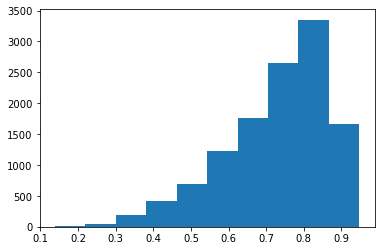

In [514]:
plt.hist(targets[:,0]) # QED

(array([ 465., 2978., 3338., 2247., 1484.,  911.,  363.,  138.,   65.,
          11.]),
 array([1.3993624, 1.9385438, 2.477725 , 3.0169065, 3.5560877, 4.095269 ,
        4.6344504, 5.1736317, 5.7128134, 6.2519946, 6.791176 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

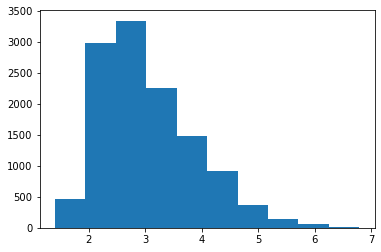

In [515]:
plt.hist(targets[:,1]) # SAS

(array([   7.,   26.,  131.,  460., 1323., 2665., 3697., 2910.,  743.,
          38.]),
 array([-4.5803    , -3.455926  , -2.3315518 , -1.2071779 , -0.08280382,
         1.0415702 ,  2.165944  ,  3.2903183 ,  4.4146924 ,  5.5390663 ,
         6.66344   ], dtype=float32),
 <BarContainer object of 10 artists>)

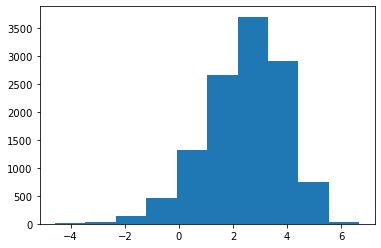

In [516]:
plt.hist(targets[:,2]) # logP

In [517]:
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

array([0.13865414, 0.52658784, 0.61501819, 0.67367953, 0.72148061,
       0.75967211, 0.79049951, 0.81994599, 0.84718364, 0.8811332 ,
       0.94739628])

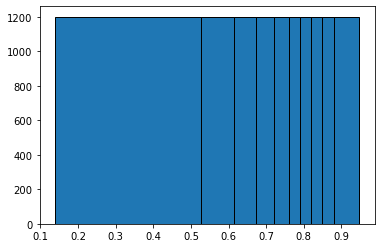

In [518]:
d = targets[:,0]

n, qed, patches = plt.hist(d, equalObs(d, 10), edgecolor='black')
qed

array([1.39936244, 2.12297773, 2.31691217, 2.50605822, 2.6943295 ,
       2.88943219, 3.09312844, 3.36582851, 3.75487804, 4.23295593,
       6.79117584])

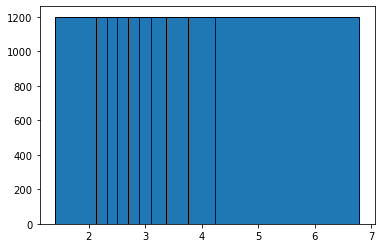

In [519]:
d = targets[:,1]

n, sas, patches = plt.hist(d, equalObs(d, 10), edgecolor='black')
sas

array([-4.58029985,  0.5219    ,  1.29509997,  1.79939997,  2.22280002,
        2.58353996,  2.94551992,  3.31381989,  3.6881001 ,  4.16680002,
        6.66344023])

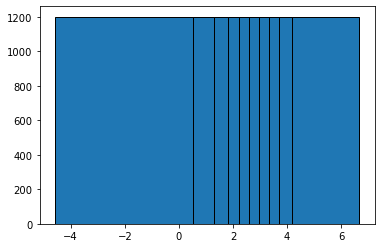

In [520]:
d = targets[:,2]

n, logP, patches = plt.hist(d, equalObs(d, 10), edgecolor='black')
logP

In [521]:
np.savez("models/zinc_eq_freq_bins_10_qed_sas_logP.npz", qed=qed, sas=sas, logP=logP)

In [490]:
label = np.digitize(b.y[:,-1], logP)
np.max(label)

11

In [483]:
data[loader.slices["train"]]

IndexError: index 167621 is out of bounds for axis 0 with size 10000

In [484]:
data = Zinc_mod(
                root="data/Zinc/", 
            
               ) 

Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index


In [486]:
for b in loader.train_dataloader():
    break

In [492]:
label = label-1

In [493]:
label[0] = -1

In [494]:
np.min(label)

-1

In [ ]:
l2 = label if label >= 0

In [498]:
l2 = np.clip(label, a_min=0, a_max=11)

In [499]:
type(l2[0])

numpy.int64